In [3]:
import sys
root_dir = "./"
sys.path.append('/Users/krishna/Desktop/Study/NLP Assignments/Course_Project/PDF')

In [4]:
import time
from layout_parser_functions import init_models, extract_pages_and_images, process_page, visualize_layout
from pdfplumber_functions import extract_words_from_pdf, generate_and_display_images_pdfplumber
from merge_boxes import merge_boxes
from treeify import generate_tree
from process_pdf import merge_pdfs,delete_pdfs,process_pdf
import json, os
from PyPDF2 import PdfMerger

In [5]:
import warnings

# Suppress specific future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Suppress all future warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [6]:
new_layout_data, pdf_tree = process_pdf(root_dir + "PDF/documents/StarFormation.pdf", use_layoutparser=True, use_pdfplumber=True, generate_images=True)

Processing page 1/23 with LayoutParser...


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Processing page 2/23 with LayoutParser...
Processing page 3/23 with LayoutParser...
Processing page 4/23 with LayoutParser...
Processing page 5/23 with LayoutParser...
Processing page 6/23 with LayoutParser...
Processing page 7/23 with LayoutParser...
Processing page 8/23 with LayoutParser...
Processing page 9/23 with LayoutParser...
Processing page 10/23 with LayoutParser...
Processing page 11/23 with LayoutParser...
Processing page 12/23 with LayoutParser...
Processing page 13/23 with LayoutParser...
Processing page 14/23 with LayoutParser...
Processing page 15/23 with LayoutParser...
Processing page 16/23 with LayoutParser...
Processing page 17/23 with LayoutParser...
Processing page 18/23 with LayoutParser...
Processing page 19/23 with LayoutParser...
Processing page 20/23 with LayoutParser...
Processing page 21/23 with LayoutParser...
Processing page 22/23 with LayoutParser...
Processing page 23/23 with LayoutParser...
LayoutParser processing took 102.28446984291077 seconds
Proces

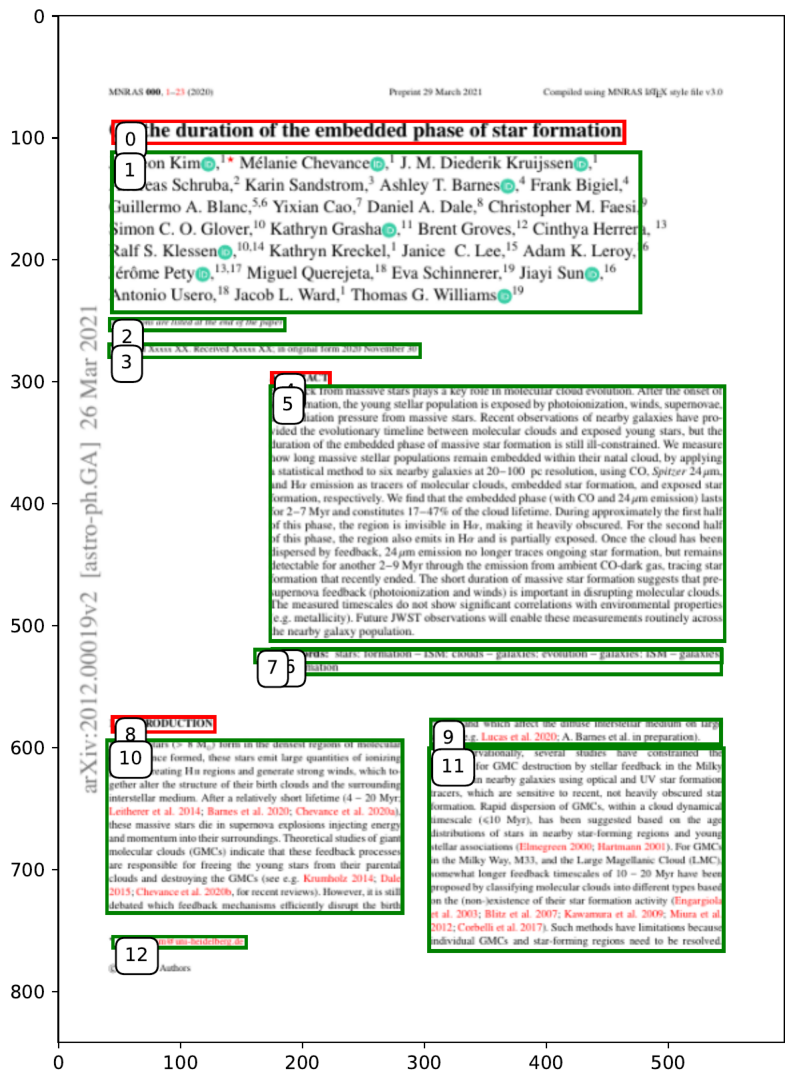

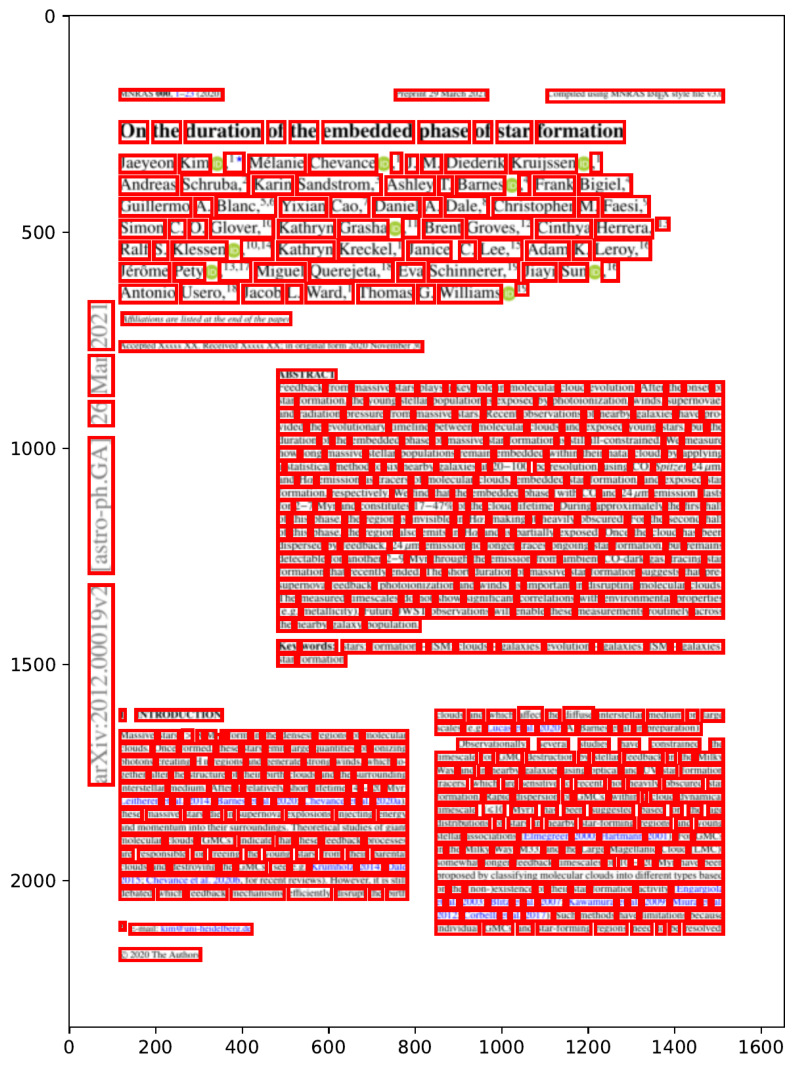

In [7]:
from pdf2image import convert_from_path
import matplotlib.pyplot as plt

layout_images = convert_from_path(root_dir + 'PDF/output/visuals/lp_output.pdf')

img = layout_images[0]
plt.figure(figsize=(10, 16))
plt.imshow(img)
plt.axis('off')
plt.show()

words_images = convert_from_path(root_dir + 'PDF/output/visuals/pdfplumber_output.pdf')

img = words_images[0]
plt.figure(figsize=(10, 16))
plt.imshow(img)
plt.axis('off')
plt.show()


In [8]:
import uuid
from IPython.display import display_javascript, display_html, display
import json

class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())

    def _ipython_display_(self):
        display_html('<div id="{}" style="height: 600px; width:100%;"></div>'.format(self.uuid), raw=True)
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
        document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str), raw=True)
        
RenderJSON(pdf_tree)

In [9]:
import json
file_path = root_dir + 'PDF/output/pdf_tree.json'

with open(file_path, 'w') as file:
    json.dump(pdf_tree, file, indent=4)

In [10]:
import json
file_path = root_dir + 'PDF/output/chunks.json'

with open(file_path, 'w') as file:
    json.dump(new_layout_data, file, indent=4)

In [11]:
import numpy as np
import json
import sentence_transformers

model = sentence_transformers.SentenceTransformer('all-MiniLM-L6-v2')

# Load JSON data from file
with open(root_dir + 'PDF/output/chunks.json', 'r') as file:
    chunks = json.load(file)

# Extract content and ids
contents = [item["content"] for item in chunks]
ids = [item["id"] for item in chunks]

# Generate embeddings for the contents
embeddings = model.encode(contents)

# Save the embeddings and ids to .npy files
np.save(root_dir + 'PDF/output/embeddings.npy', embeddings)
np.save(root_dir + 'PDF/output/ids.npy', ids)


In [12]:
user_query = "Earliest phase of star formation.\n"
query_embed = model.encode([user_query])

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings and ids from .npy files
embeddings = np.load(root_dir + 'PDF/output/embeddings.npy')
ids = np.load(root_dir + 'PDF/output/ids.npy', allow_pickle=True)


# Calculate cosine similarity between query and all embeddings
similarities = cosine_similarity(query_embed, embeddings)

# Find the top 4 indices
top_indices = np.argsort(similarities[0])[::-1][:10]
top_scores = np.sort(similarities[0])[::-1][:10]

# Retrieve and print the corresponding strings and scores
for index, score in zip(top_indices, top_scores):
    content_id = ids[index]

    # Assuming chunks is the list of dictionaries loaded from 'chunks.json'
    corresponding_string = "No matching content found"
    for item in chunks:
        if item["id"] == content_id:
            corresponding_string = item["content"]
            break

    print(corresponding_string)


On the duration of the embedded phase of star formation
4.2 Heavily obscured phase of star formation
of star formation and finally in Hα when the star-forming regions become (partially) exposed.
The age estimates of the exposed star-forming regions (re- ferred to as C-type in Corbelli et al. 2017) from spectral energy distribution (SED) fitting are available in Sharma et al. (2011), and are obtained using photometric data at various wavelengths simul- taneously,such asUV, Hα, and24µm. Theage ofthe C-typephase corresponds to the time it takes for the cloud to evolve from the end of the heavily obscured phase of star formation (observed with 24µm but without Hα) to the end of the exposed young stellar re- gion phase (both 24µm and Hα are observed). This duration there- fore corresponds to t 24µm − t obscured in our analysis. Corbelli et al. (2017) find that the C-type phase in M33 lasts for 8 Myr (without quoted uncertainty), which is in excellent agreement with our mea- surement of 8.4+

In [14]:
from transformers import BertTokenizer, EncoderDecoderModel

finetuned_bert_model = EncoderDecoderModel.from_pretrained("checkpoint-53835/")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [15]:
user_query = "earliest phase of star formation\n"
query_embed = model.encode([user_query])

from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings and ids from .npy files
embeddings = np.load(root_dir + 'PDF/output/embeddings.npy')
ids = np.load(root_dir + 'PDF/output/ids.npy', allow_pickle=True)


# Calculate cosine similarity between query and all embeddings
similarities = cosine_similarity(query_embed, embeddings)

# Find the top 4 indices
top_indices = np.argsort(similarities[0])[::-1][:10]
top_scores = np.sort(similarities[0])[::-1][:10]

# Retrieve and print the corresponding strings and scores
for index, score in zip(top_indices, top_scores):
    content_id = ids[index]

    # Assuming chunks is the list of dictionaries loaded from 'chunks.json'
    corresponding_string = "No matching content found"
    for item in chunks:
        if item["id"] == content_id:
            corresponding_string = item["content"]
            break

from transformers import BertTokenizer, EncoderDecoderModel

finetuned_bert_model = EncoderDecoderModel.from_pretrained("checkpoint-53835/")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

article = user_query + corresponding_string
input_ids = tokenizer(article, return_tensors="pt").input_ids
output_ids = finetuned_bert_model.generate(input_ids)

print(tokenizer.decode(output_ids[0], skip_special_tokens=True))


first phase of star formation we present a characterisation of the evolutionary timeline from molecular clouds to young stellar regions in six nearby galaxies. we measure the duration of the 24 - month emission phase ( t - 24 ), the du - 24 sentinel. this is the time of the year, when massive star fb, 24, and 24 - 7. the average distance between independent obscured regions evolving from clouds to massive star formation.
